# Robertson
The Robertson problem involves three coupled equations: two first-order ordinary differential equations (ODEs), and one alebrqaic constraint. The variables $y$ represent chemical concentrations within a reacting system. Mathematically, the problem is expressed as

\begin{align}
    \dot{y}_0 &= -0.04y_0 + 10^4y_1y_2, \\
    \dot{y}_1 &= 0.04y_0 - 10^4y_1y_2 - 3\times10^7y_1^2, \\
    1 &= y_0 + y_1 + y_2
\end{align}

The constant parameters above are chosen to match those available in a similar example from [MATLAB](https://www.mathworks.com/help/matlab/math/solve-differential-algebraic-equations-daes.html) for ease of comparison. This problem is commonly used to check the performance of differential algebraic equation (DAE) solvers that handle stiff systems. In this tutorial we will use the Robertson problem as a straightforward example to demonstrate the IDA solver.

## Problem setup
While there are two solvers included in scikit-SUNDAE (i.e., IDA and CVODE), only the IDA solver can handle DAEs. While the interface is similar to the CVODE solver, there are a few key differences to be aware of when defining a DAE. This is particularly important because the IDA solver can also solve pure ODEs, so it is left to the user to understand how to correctly input the relevant options to specify that the system is a DAE rather than an ODE.

The main keyword arguments you will use for the IDA solver that do not exist for the CVODE solver are `algebraic_idx` and `calc_initcond`. The `algebraic_idx` argument should ALWAYS be specified for a DAE. The only reason the documentation lists it as optional is because it can be left out when using the IDA solver for pure ODE problems (i.e., when there are no algebraic constraints). While the `calc_initcond` argument will commonly be used, it is not always necessary, as discussed below.

The IDA solver is accessed by creating an instance of the `sundae.ida.IDA` class. The only required input is a residual function (`resfn`) that defines the system of equations. Rather than a return value, `resfn` must have a signature like `f(t, y, yp, res)` where `res` is a pre-allocated array that can be filled with residual expressions inside the function. Residual expressions are expressions that are equal to zero. If a variable is differential, i.e., $\dot{y}_i = f(t, y)$, then the equivalent residual expression is ${\rm res_i} = \dot{y}_i - f(t, y)$. All algebraic constraints can also always be written as a residual expression by moving all terms to the right hand side, $0 = g(t, y, \dot{y})$. Written in terms of residuals, the Robertson problem becomes

\begin{align}
    {\rm res}_0 &= \dot{y}_0 + 0.04y_0 - 10^4y_1y_2, \\
    {\rm res}_1 &= \dot{y}_1 - 0.04y_0 + 10^4y_1y_2 + 3\times10^7y_1^2, \\
    {\rm res}_2 &= y_0 + y_1 + y_2 - 1.
\end{align}

The IDA-compatible Python function for this system of residuals is given below.  

In [1]:
import numpy as np
import sksundae as sun
import matplotlib.pyplot as plt

def resfn(t, y, yp, res):
    res[0] = yp[0] + 0.04*y[0] - 1e4*y[1]*y[2]
    res[1] = yp[1] - 0.04*y[0] + 1e4*y[1]*y[2] + 3e7*y[1]**2
    res[2] = y[0] + y[1] + y[2] - 1

## Solve and plot
Now that `resfn` is defined, it can be used to create an instance of `IDA`. Recall from above that because this system represents a DAE, the `algebraic_idx` argument MUST also be specified when initializing the solver. This argument includes a list of which indices within $y$ contain purely algebraic variables. In other words, what are the indices $i$ for which a $\dot{y}_i$ does not exist? In the Robertson problem, the only algebraic variable is $y_2$. Therefore, as shown below, `algebraic_idx=[2]`. Note that even when there is only one algebraic variable, the input to `algebraic_idx` must always be a list. In the special case when no variables are algebraic, your system is a pure ODE and `algebraic_idx` does not need to be set. While the IDA solver will handle these types of problems just fine, you may still want to switch over to the CVODE solver in these cases. Since CVODE is strictly for ODEs, there can be performance benefits from using it over IDA when both solvers are compatible with your problem. Aside from the `algebraic_idx` keyword argument, the absolute tolerance `atol` is set to `1e-8` rather than using the default `1e-6` because $y_1$ happens to have a very small value, as you will see in the solution.

Once the solver is constructed, it can be run using one of two methods: `step` or `solve`. The `solve` method integrates over a defined time span while the `step` method performs one integration step at at time. First, we'll demonstrate how to use the `solve` method, which requires the integration time span and initial conditions for both `y0` and `yp0` (i.e., the values of $y$ and $\dot{y}$ at `tspan[0]`). Note that it is typical that you will only know one of `y0` or `yp0`, but not both. We will discuss how to deal with this below.

The solver detects how the solution should be recorded in time based on the length of `tspan`. When given exactly two values, the solver returns the solution at internally chosen time steps between the two values. When it is important to evaluate the solution at specific times, `tspan` should be an array with length greater than 2, specifying the times at which the solution should be recorded for output, as demonstrated below.


   message: Reached specified tstop.
   success: True
    status: 1
         t: [ 1.000e-06  1.758e-06 ...  5.690e+05  1.000e+06]
         y: [[ 1.000e+00  0.000e+00  0.000e+00]
             [ 1.000e+00  3.030e-08  1.239e-14]
             ...
             [ 3.518e-03  1.412e-08  9.965e-01]
             [ 2.031e-03  8.142e-09  9.980e-01]]
        yp: [[-4.000e-02  4.000e-02  0.000e+00]
             [-4.000e-02  4.000e-02  2.888e-08]
             ...
             [-5.982e-09 -2.409e-14  5.982e-09]
             [-1.989e-09 -7.966e-15  1.989e-09]]
  i_events: None
  t_events: None
  y_events: None
 yp_events: None
      nfev: 570
      njev: 63



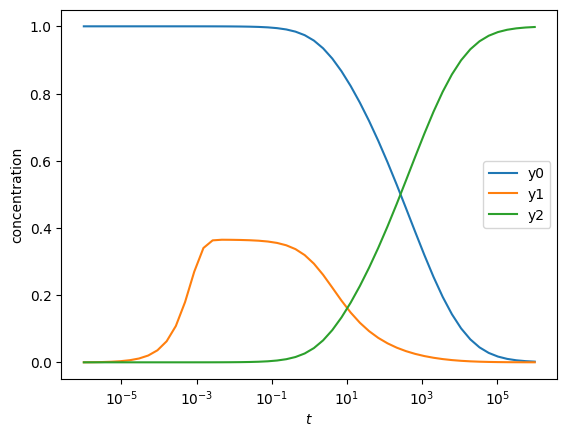

In [2]:
tspan = np.logspace(-6, 6, 50)
y0 = np.array([1, 0, 0])
yp0 = np.array([-0.04, 0.04, 0])
    
solver = sun.ida.IDA(resfn, atol=1e-8, algebraic_idx=[2])
soln = solver.solve(tspan, y0, yp0)
print(soln)

soln.y[:,1] *= 1e4  # scale the y1 values for plotting

plt.semilogx(soln.t, soln.y)
plt.legend(['y0', 'y1', 'y2'])
plt.xlabel(r"$t$");
plt.ylabel("concentration");

## Initial conditions
In the previous cell we explicitly defined both `y0` and `yp0` when calling the `solve` method. For a small problem this isn't particularly surprising. Given only `y0`, we can set each of the residual expressions equal to zero to determine `yp0`. However, for large problems this processes can become cumbersome and complicated. Luckily, the IDA solver includes a `calc_initcond` option that helps calculate a consistent initial condition given only one of `y0` or `yp0`. Below, instead of giving the correct, known values for `yp0`, we initialize the values as an array of zeros and demonstrate how to let the solver determine these values.

When `calc_initcond='yp0'`, the solver adjusts the algebraic $y$ variables and the $\dot{y}$ array to force the residual expressions to zero. The internal solver state is saved before the first time step is taken. If you have more confidence in your `yp0` values, you can alternatively set `calc_initcond='y0'` to solve for the `y0` values rather than the `yp0` values. When this option is not given, no adjustments are made to either initial condition. Instead, the solver assumes that both are correct and tries to integrate right away, without checking that the initial conditions are self consistent. Therefore, it is generally best practice to always use this option. When provided, the solver is generally more stable and less likely to raise an error, especially in early time steps.

Since we are integrating in the forward direction in time (i.e., `tspan` is monotonically increasing) there is one more option that we do not need to set here, but becomes important if you are integrating in the reverse direction (decreasing times). This option is called `calc_init_dt`, which is the relative time step that is used when correcting the initial condition. The default is 0.01 which is a small positive time step that informs the solver that integration will be in the increasing direction. In cases where you might be integrating in the reverse direction, you will want to set this option to a small negative value instead so that the solver knows that times will be expected to decrease during each integration step.

In line 9 below, and in the printed output, we show that the initial condition calculation was successful and matches the known solution to `yp0` from above. Note that while the cell below uses the `solve` method to integrate over a full time span in one call, the initial condition correction can also be used for the `step` method discussed below. In either case, the option must be specified when the class is initialized. Within the `solve` method, the correction step is applied automatically before the first integration step. When using the `step` method, the correction is applied prior to the first step by calling `init_step`, as shown in the following section.


   message: Reached specified tstop.
   success: True
    status: 1
         t: [ 1.000e-06  1.758e-06 ...  5.690e+05  1.000e+06]
         y: [[ 1.000e+00  0.000e+00  1.202e-12]
             [ 1.000e+00  3.030e-08  1.229e-14]
             ...
             [ 3.518e-03  1.412e-08  9.965e-01]
             [ 2.031e-03  8.142e-09  9.980e-01]]
        yp: [[-4.000e-02  4.000e-02  0.000e+00]
             [-4.000e-02  4.000e-02  2.853e-08]
             ...
             [-5.982e-09 -2.409e-14  5.982e-09]
             [-1.989e-09 -7.966e-15  1.989e-09]]
  i_events: None
  t_events: None
  y_events: None
 yp_events: None
      nfev: 573
      njev: 65



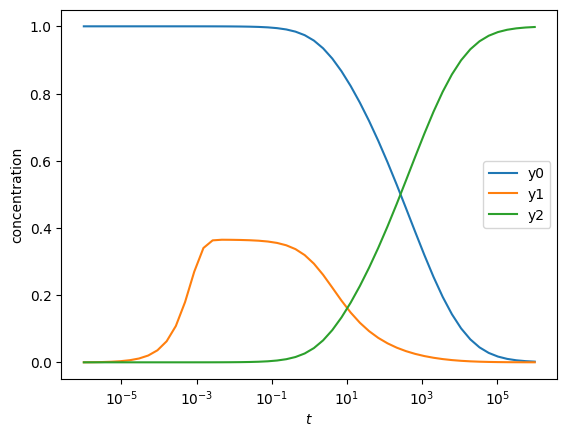

In [3]:
tspan = np.logspace(-6, 6, 50)
y0 = np.array([1, 0, 0])
yp0 = np.zeros_like(y0)
    
solver = sun.ida.IDA(resfn, atol=1e-8, algebraic_idx=[2], calc_initcond='yp0')
soln = solver.solve(tspan, y0, yp0)
print(soln)

assert np.allclose(soln.yp[0], [-0.04, 0.04, 0])  # check that yp0 is correct

soln.y[:,1] *= 1e4  # scale the y1 values for plotting

plt.semilogx(soln.t, soln.y)
plt.legend(['y0', 'y1', 'y2'])
plt.xlabel(r"$t$");
plt.ylabel("concentration");

## Step-wise solutions
Solving step-by-step instead of across a full time span can be beneficial in some cases, especially for debugging. Therefore, a `step` method is also available in `IDA`. Before taking a step, the solver needs to know the initial conditions and time to determine the direction of integration for the following steps. Thus, before calling `step`, you should call `init_step`, as shown below. The initialization is handled automatically when using the `solve` method but must be done manually in a step-by-step approach. Since we are using the same solver instance that we initialized above, the `init_step` call will also provide a correction to `yp0` as specified by the `calc_initcond` option.

Below, we run `init_step` and compare the solution `soln_0` to the initial values from the full solve, from above. Afterward, we take a step evaluated at `soln.t[10]` using the solution object from the full solve, allowing us to compare the step-by-step solution to a portion of the full solution. We only check that the solutions are within some tolerance (`1e-6`) because the solver's internal steps may differ from those in the full solution, meaning the values will be close but may not be exactly the same.

In [4]:
soln.y[:,1] /= 1e4  # unscale y1 for comparison to step-wise solution

soln_0 = solver.init_step(tspan[0], y0, yp0)
print(soln_0)

assert soln_0.t == soln.t[0]
assert np.all(soln_0.y - soln.y[0] < 1e-6)

soln_1 = solver.step(soln.t[10])
print(soln_1)

assert soln_1.t == soln.t[10]
assert np.all(soln_1.y - soln.y[10] < 1e-6)


   message: Successful function return.
   success: True
    status: 0
         t: 1e-06
         y: [ 1.000e+00  0.000e+00  1.202e-12]
        yp: [-4.000e-02  4.000e-02  0.000e+00]
  i_events: None
  t_events: None
  y_events: None
 yp_events: None
      nfev: 3
      njev: 2


   message: Successful function return.
   success: True
    status: 0
         t: 0.0002811768697974231
         y: [ 1.000e+00  1.085e-05  3.565e-07]
        yp: [-4.000e-02  3.641e-02  3.588e-03]
  i_events: None
  t_events: None
  y_events: None
 yp_events: None
      nfev: 21
      njev: 9



## Advanced features
The IDA solver offers many advanced settings and controls. While we won't cover all of them in detail, we will discuss two important ones: (1) event functions and (2) Jacobian functions.

### Event functions
Event functions allow the solver to record solutions based on some criteria of interest, and if requested, can also terminate the solution when the criteria occurs. As a basic example, imagine throwing a ball straight up in the air and tracking its vertical position. You may want to record the time and location in which the ball reaches a maximum height, and also may want to force the solver the quit when the ball hits the ground so that you do not end up with unphysical solutions (i.e., the ball had negative height). To allow the solver to track events, you need to define a function with a signature like `f(t, y, yp, events)`. Inside the function, the `events` array should be filled with expressions that define an event. An event is triggered if any `events[i] = 0` during the solve. The solver needs to know two things when using events: (1) the events function itself, passed using the `eventsfn` keyword argument, and (2) the number of events to track, passed using `num_events`. Below we set up three events that track when `y[0] = 0.1`, when `y[1]*1e4 = 0.2`, and when `y[2] = 0.7`.

After being defined, you may also decide to change the optional `terminal` and `direction` attributes for your event function. These attributes dictate what happens when an event occurs. Each attribute must be a list with the same number of values as `num_events`, allowing each event to have its own terminal and direction behavior. `terminal` values can be `True` or `False` to specify that the solver should or should not stop integrating when the specified event occurs, respectfully. You can also set an integer `terminal` value to tell the solver that it should only exit after the corresponding event has occurred some number of times. `direction` specifies when an event should be ignored based on the sign change of an `events[i]` expression. In the example below, the `terminal` and `direction` values are set to do the following:

* Stop the integration early if `y[0] = 0.1` occurs, but do not stop if either of the other events occur. Instead simply record those events, but continue integrating toward `tspan[-1]`.
* Track and count `events[0]` and `events[1]` if either of those expressions have sign changes, regardless of the direction (i.e., positive to negative or negative to positive). However, `events[2]` should only be detected if it occurs with a negative slope (i.e., moves from a positive to a negative value.)


   message: Detected one or more events.
   success: True
    status: 2
         t: [ 1.000e-06  1.758e-06 ...  1.099e+04  1.114e+04]
         y: [[ 1.000e+00  0.000e+00  1.202e-12]
             [ 1.000e+00  3.030e-08  1.229e-14]
             ...
             [ 1.009e-01  4.484e-07  8.991e-01]
             [ 1.000e-01  4.438e-07  9.000e-01]]
        yp: [[-4.000e-02  4.000e-02  0.000e+00]
             [-4.000e-02  4.000e-02  2.853e-08]
             ...
             [-6.032e-06 -2.976e-11  6.032e-06]
             [-5.908e-06 -2.909e-11  5.908e-06]]
  i_events: [[ 0  1  0]
             [ 0 -1  0]
             [-1  0  0]]
  t_events: [ 5.654e-04  5.656e+00  1.114e+04]
  y_events: [[ 1.000e+00  2.000e-05  2.576e-06]
             [ 8.833e-01  2.000e-05  1.167e-01]
             [ 1.000e-01  4.438e-07  9.000e-01]]
 yp_events: [[-4.000e-02  2.798e-02  1.202e-02]
             [-1.200e-02 -1.217e-06  1.200e-02]
             [-5.908e-06 -2.909e-11  5.908e-06]]
      nfev: 403
      njev: 55



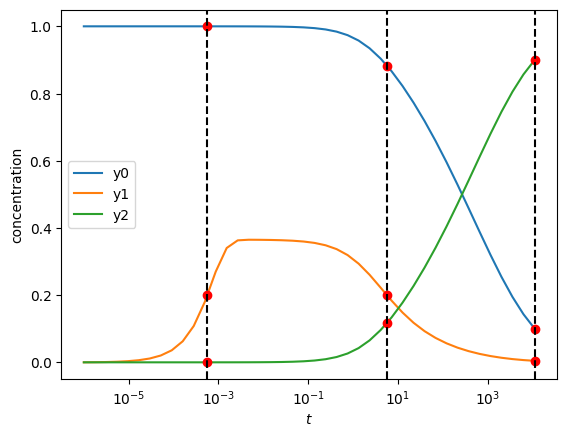

In [5]:
def eventsfn(t, y, yp, events):
    events[0] = y[0] - 0.1
    events[1] = y[1]*1e4 - 0.2
    events[2] = y[2] - 0.7
    
eventsfn.terminal = [True, False, False]
eventsfn.direction = [0, 0, -1]
    
solver = sun.ida.IDA(resfn, algebraic_idx=[2], calc_initcond='yp0',
                     atol=1e-8, eventsfn=eventsfn, num_events=3)

soln = solver.solve(tspan, y0, yp0)
print(soln)

soln.y[:,1] *= 1e4  # scale the y1 values for plotting
soln.y_events[:,1] *= 1e4  # scale the y1 values for plotting

plt.semilogx(soln.t, soln.y, '-', soln.t_events, soln.y_events, 'or')
plt.legend(['y0', 'y1', 'y2'])
plt.xlabel(r"$t$");
plt.ylabel("concentration");

for t in soln.t_events:
    plt.axvline(t, linestyle='--', color='k')

The solution output demonstrates that the events were tracked correctly. All specified events were tracked and recorded according to the specified settings. In addition to the `t_events`, `y_events`, and `yp_events` values in the solution object, which are self explanatory, the `i_events` field gives you information on which event triggered each record and which direction the event was detected going when it was recorded. For example, the first row means that the `events[1]` expression was detected with positive slope.

There are a couple more things you should be aware of if you decide to use events. First, if you don't specify `terminal` or `direction`, the default behavior is to make all events terminate integration on their first occurrence and to track both positive and negative slopes for each `events[i]`. Lastly, when an event is terminal, the results for that event occurrence are output to both the main arrays (`t`, `y`, and `yp`) and the "events" arrays (`t_events`, `y_events`, and `yp_events`) within the solution object. In contrast, if an event is not terminal, it is only recoded in the "events" arrays.

### Jacobian functions
In this simple and small problem, the solver is already fast and requires minimal computational effort. However, for larger problems, you can benefit from explicitly defining the Jacobian of your system. When the Jacobian is not provided, the solver numerically approximates it by perturbing the state variables $y$ and their derivatives $\dot{y}$. For large systems of equations, this numerical approximation can be time-consuming, especially if performed frequently, which may significantly slow down the integrator. In such a case, you may benefit from defining the Jacobian function yourself. The Jacobian is defined as 

\begin{equation}
    J_{ij} = \frac{dF_i}{dy_j} + c_j\frac{dF_i}{d\dot{y}_j},
\end{equation}

where $F_i$ are the residual expressions from `resfn`. $y_j$ and $\dot{y}_j$ are the variables and their time derivatives from the problem statement. $c_j$ is an internally determined scalar that SUNDIALS adapts based on the current step size and order. You do not need to define $c_j$, but you should not forget to include it as necessary. Note that the Jacobian is a 2D array where each row corresponds to a residual expression and each column is associated with a specific $y$ and $\dot{y}$ pair. The Jacobian function must have a signature like `f(t, y, yp, res, cj, JJ)` where `JJ` is a pre-allocated 2D array that should be filled within the function. The Jacobian function for the Robertson problem is given below and is passed to the solver using the `jacfn` keyword argument.


   message: Reached specified tstop.
   success: True
    status: 1
         t: [ 1.000e-06  1.758e-06 ...  5.690e+05  1.000e+06]
         y: [[ 1.000e+00  0.000e+00  5.294e-23]
             [ 1.000e+00  3.030e-08  1.239e-14]
             ...
             [ 3.518e-03  1.412e-08  9.965e-01]
             [ 2.031e-03  8.142e-09  9.980e-01]]
        yp: [[-4.000e-02  4.000e-02  0.000e+00]
             [-4.000e-02  4.000e-02  2.888e-08]
             ...
             [-5.979e-09 -2.411e-14  5.979e-09]
             [-1.989e-09 -7.987e-15  1.989e-09]]
  i_events: None
  t_events: None
  y_events: None
 yp_events: None
      nfev: 658
      njev: 57



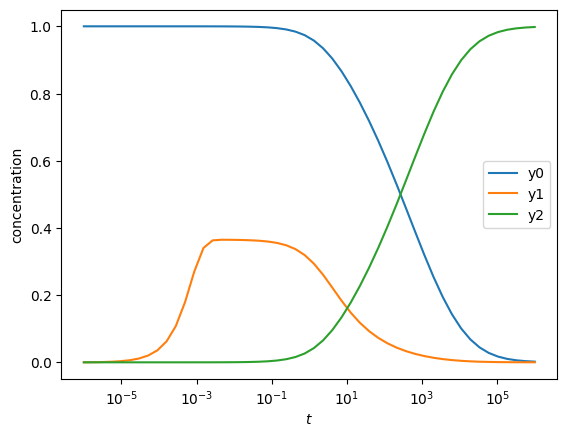

In [6]:
def jacfn(t, y, yp, res, cj, JJ):
    JJ[0,0] = 0.04 + cj
    JJ[0,1] = -1e4*y[2]
    JJ[0,2] = -1e4*y[1]
    JJ[1,0] = -0.04
    JJ[1,1] = 1e4*y[2] + 6e7*y[1] + cj
    JJ[1,2] = 1e4*y[1]
    JJ[2,0] = 1
    JJ[2,1] = 1
    JJ[2,2] = 1
    
solver = sun.ida.IDA(resfn, algebraic_idx=[2], calc_initcond='yp0', atol=1e-8,
                     jacfn=jacfn)

soln = solver.solve(tspan, y0, yp0)
print(soln)

soln.y[:,1] *= 1e4  # scale the y1 values for plotting

plt.semilogx(soln.t, soln.y)
plt.legend(['y0', 'y1', 'y2'])
plt.xlabel(r"$t$");
plt.ylabel("concentration");

You should consider providing the Jacobian for your problem when the number of Jacobian evaluations (`njev`) is large or when the problem size is substantial and the solver is slow to return results.

In some cases, you may also be able to speed up the solver without explicitly providing the Jacobian. If your problem has a banded Jacobian, you can switch to the banded solver using the option `linsolver='band'` when initializing your class. You will also need to specify the lower and upper bandwidths using the `lband` and `uband` options. This approach avoids the need to explicitly write out the Jacobian. The numerical algorithm for approximating banded Jacobians is significantly more efficient than the default `dense` method for problems having sparse Jacobians with narrow bandwidths. However, if the bandwidth is large, it may still be beneficial to explicitly provide `jacfn`. Both `dense` and `band` linear solvers support the `jacfn` option, but the `band` option will generally be faster if your bandwidth is less than the full matrix dimensions.